In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lib

import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder
from torchsummary import summary
from pytorch_lightning.loggers import WandbLogger
import wandb

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split
from scipy import stats
import plotly.express as px
import seaborn as sns

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.auto import tqdm
import os
from collections import defaultdict
import pickle
import datetime

from IPython.display import clear_output

sns.set_theme()
matplotlib.rcParams['figure.figsize'] = (30, 5)

2023-01-16 15:55:44.065925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 15:55:44.232504: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-16 15:55:45.005907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-16 15:55:45.005986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
IMAGE_SHAPE = (384, 512)
SAL_RESIZE = (12, 16)
DATA_ROOT = Path('iqa')
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [4]:
class IQADataset(Dataset):
    def __init__(self, images_path, labels_path, mode, saliency_path=None, transforms=None):
        assert isinstance(images_path, str) or isinstance(images_path, Path)
        assert isinstance(labels_path, str) or isinstance(labels_path, Path)
        assert saliency_path is None or isinstance(saliency_path, str) or isinstance(saliency_path, Path)
        assert mode in ['train', 'valid', 'test', 'all']
        assert transforms is None or isinstance(transforms, dict) and np.all([isinstance(t, A.BaseCompose) for t in transforms.values()])

        TRAIN_RATIO = 0.7
        TRAIN_VALID_RATIO = 0.8

        self.images_path = images_path
        self.labels_path = labels_path
        self.saliency_path = saliency_path

        self.saliency = True if saliency_path is not None else False

        df = pd.read_csv(labels_path).astype('float32', errors='ignore')
        available = os.listdir(images_path)
        df = df[df.name.isin(available)]

        train_size = int(TRAIN_RATIO * len(df))
        train_valid_size = int(TRAIN_VALID_RATIO * len(df))

        self.mode = mode

        if mode == 'train':
            self.df = df.iloc[:train_size]
        elif mode == 'valid':
            self.df = df.iloc[train_size:train_valid_size]
        elif mode == 'test':
            self.df = df.iloc[train_valid_size:]
        elif mode == 'all':
            self.df = df

        self.transforms = transforms
        self.file2suffix_saliency = {Path(file).with_suffix(''): Path(file).suffix for file in os.listdir(saliency_path)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> tuple:
        name, subj_mean, subj_std = self.df.iloc[index]
        image = cv2.imread(str(self.images_path / name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.saliency:
            name_clean= Path(name).with_suffix('')
            name_sal = str(name_clean) + self.file2suffix_saliency[name_clean]
            name_sal = str(self.saliency_path / name_sal)
            saliency = cv2.imread(name_sal)
            saliency = saliency[..., 0:1]

        if self.transforms:
            NUM_CHANNELS = 3

            # first stage: preprocessing (resize)
            image = self.transforms['1_both'](image=image)['image']
            if self.saliency:
                saliency = self.transforms['1_both'](image=saliency)['image']
            image = np.dstack([image, saliency])

            # second stage: augmentations (hflip, rotate)
            image = self.transforms['2_both'](image=image)['image']

            # third stage: postprocessing (normalization, to_tensor)
            image, saliency = image[..., :NUM_CHANNELS], image[..., NUM_CHANNELS:]
            image = self.transforms['3_images'](image=image)['image']
            if self.saliency:
                saliency = self.transforms['3_saliency'](image=saliency)['image']
        
        out = {'image': image, 'name': name, 'subj_mean': subj_mean, 'subj_std': subj_std}
        if self.saliency:
            out['saliency'] = saliency
        return out

In [5]:
transforms = {
    '1_both': A.Compose([
        A.Resize(*IMAGE_SHAPE),
    ]),
    '2_both': A.Compose([
        A.HorizontalFlip()
    ]),
    '3_images': A.Compose([
        A.Normalize(),
        ToTensorV2(),
    ]),
    '3_saliency': A.Compose([
        A.Resize(*SAL_RESIZE),
        A.ToFloat(max_value=255),
        ToTensorV2(),
    ])
}

dataset_train = IQADataset(
    images_path=DATA_ROOT / 'koniq10k' / 'images',
    labels_path=DATA_ROOT / 'koniq10k' / 'data.csv',
    saliency_path=DATA_ROOT / 'koniq10k' / 'saliency_maps',
    mode='train', 
    transforms=transforms)

dataset_valid = IQADataset(
    images_path=DATA_ROOT / 'koniq10k' / 'images',
    labels_path=DATA_ROOT / 'koniq10k' / 'data.csv',
    saliency_path=DATA_ROOT / 'koniq10k' / 'saliency_maps',
    mode='valid', 
    transforms=transforms)

dataset_test_koniq = IQADataset(
    images_path=DATA_ROOT / 'koniq10k' / 'images',
    labels_path=DATA_ROOT / 'koniq10k' / 'data.csv', 
    saliency_path=DATA_ROOT / 'koniq10k' / 'saliency_maps',
    mode='test', 
    transforms=transforms)

dataset_test_clive = IQADataset(
    images_path=DATA_ROOT / 'CLIVE' / 'images',
    labels_path=DATA_ROOT / 'CLIVE' / 'data.csv',
    saliency_path=DATA_ROOT / 'CLIVE' / 'saliency_maps',
    mode='all', 
    transforms=transforms)


loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=16)
loader_valid = DataLoader(dataset_valid, batch_size=16, shuffle=False, num_workers=16)
loader_test_koniq = DataLoader(dataset_test_koniq, batch_size=16, shuffle=False, num_workers=16)
loader_test_clive = DataLoader(dataset_test_clive, batch_size=16, shuffle=False, num_workers=16)

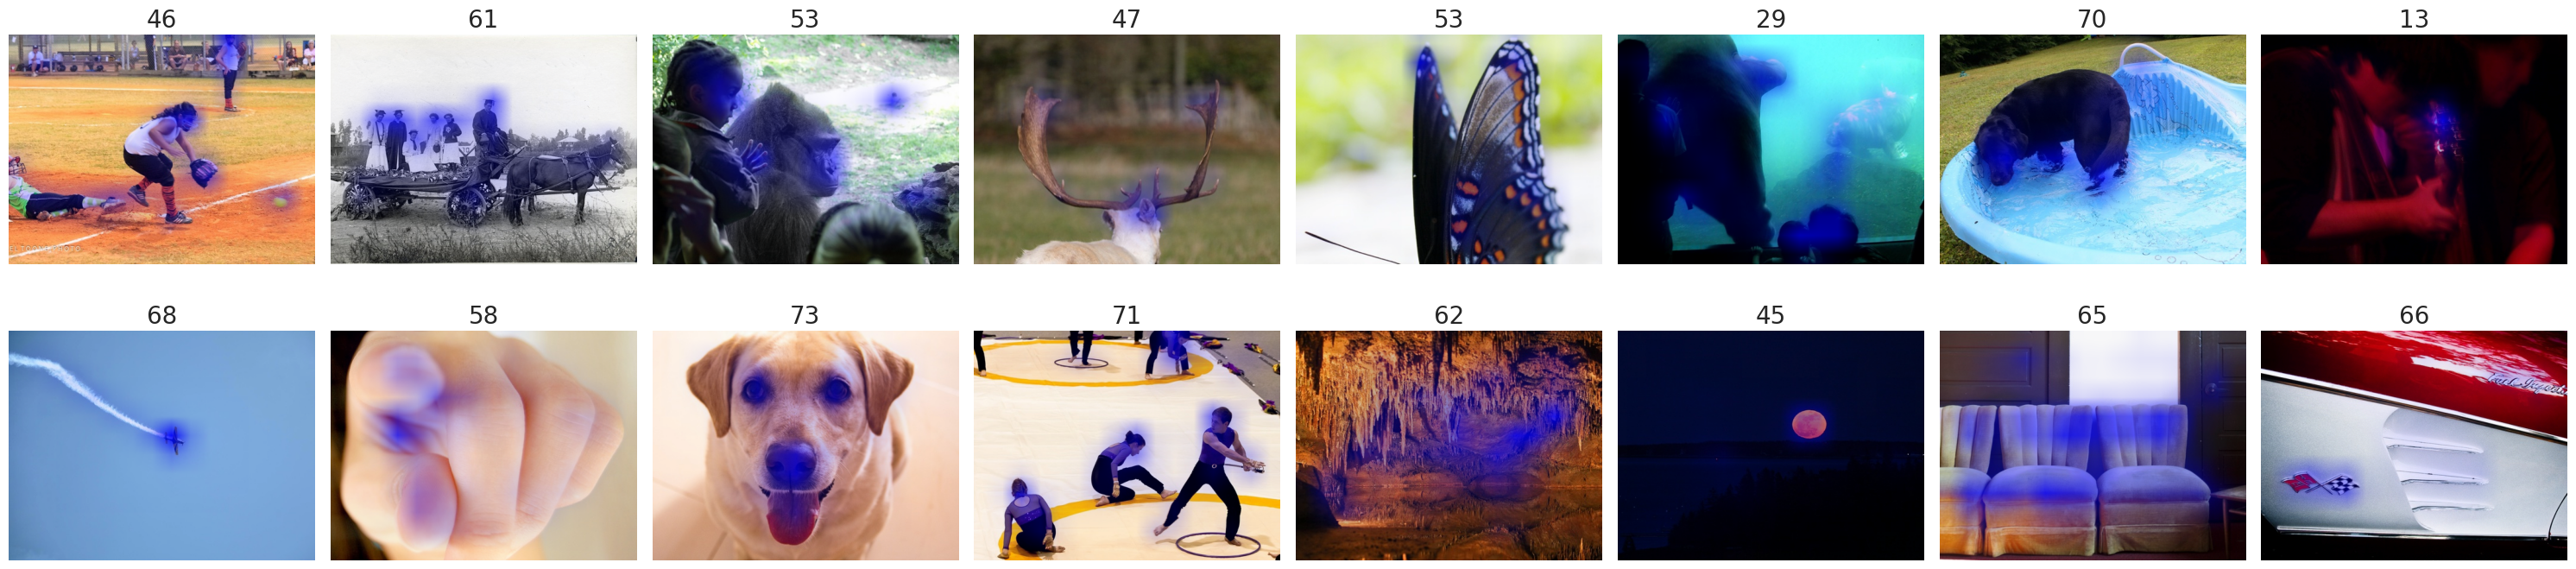

In [6]:
batch = next(iter(loader_train))
lib.display_batch(batch, 'subj_mean')

In [7]:
class LinearBlock(nn.Module):
    def __init__(self, in_dim, out_dim, dropout, activation=True):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        if activation:
            self.layers = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
            )
        else:
            self.layers = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_dim, out_dim),
            )

    def forward(self, x):
        return self.layers(x)

class Model(pl.LightningModule):
    def __init__(self, saliency_flg, alpha_sal=0.2):
        super().__init__()

        backbone = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        backbone = list(backbone.children())[:-2]
        backbone = nn.Sequential(*backbone)
        self.backbone = backbone
        
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            LinearBlock(1408, 1024, 0.25),
            LinearBlock(1024, 256, 0.25),
            LinearBlock(256, 1, 0, activation=False)
        )

        self.sal_conv = nn.Conv2d(1408, 1, (1, 1), 1, 0)
        self.mse_loss = nn.MSELoss()
        self.alpha_sal = alpha_sal if saliency_flg is True else 0
        self.saliency_flg = saliency_flg

    def saliency_loss(self, pred, y):
        pred = pred / pred.mean()
        y = y / y.mean()
        return ((pred - y) ** 2).mean()

    def forward(self, x):
        x = self.backbone(x)
        if self.saliency_flg:
            saliency = self.sal_conv(x)
            x = saliency * x # fusion
        x = self.mlp(x)

        if self.saliency_flg:
            return x, saliency
        else:
            return x

    def training_step(self, batch, batch_idx):
        return self._step(batch)
    
    def validation_step(self, batch, batch_idx):
        return self._step(batch)

    def test_step(self, batch, batch_idx):
        return self._step(batch)

    def _step(self, batch):
        x, sal_target, y = batch['image'], batch['saliency'], batch['subj_mean']

        if self.saliency_flg:
            pred, sal_pred = self(x)
        else:
            pred = self(x)
        pred = pred.flatten()

        loss = self.mse_loss(pred, y) * (1 - self.alpha_sal)
        if self.saliency_flg:
            loss += self.saliency_loss(sal_pred, sal_target) * self.alpha_sal

        true = y.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        return {'loss': loss, 'results': (true, pred)}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam([
            {'params': self.backbone.parameters(), 'lr': 3e-5},
            {'params': self.mlp.parameters(), 'lr': 3e-4}
        ], weight_decay=3e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.2, 
            patience=5, 
            verbose=True)
            
        lr_dict = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_srocc"
        } 

        return [optimizer], [lr_dict]

    def training_epoch_end(self, outputs):
        """log and display average test loss and accuracy"""
        loss, plcc, srocc = self._epoch_end(outputs)

        self.print(f"| TRAIN plcc: {plcc:.2f}, srocc: {srocc:.2f}, loss: {loss:.2f}" )

        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_plcc', plcc, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_srocc', srocc, prog_bar=True, on_epoch=True, on_step=False)

    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        loss, plcc, srocc = self._epoch_end(outputs)

        self.print(f"[Epoch {self.trainer.current_epoch:3}] VALID plcc: {plcc:.2f}, srocc: {srocc:.2f}, loss: {loss:.2f}", end= " ")

        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_plcc', plcc, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_srocc', srocc, prog_bar=True, on_epoch=True, on_step=False)

    def test_epoch_end(self, outputs):
        """log and display average test loss and accuracy"""
        loss, plcc, srocc = self._epoch_end(outputs)

        self.log(f'{self._test_dashboard}_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f'{self._test_dashboard}_plcc', plcc, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f'{self._test_dashboard}_srocc', srocc, prog_bar=True, on_epoch=True, on_step=False)

    def _epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        true = np.concatenate([x['results'][0] for x in outputs])
        predicted = np.concatenate([x['results'][1] for x in outputs])
        
        plcc = stats.pearsonr(predicted, true)[0]
        srocc = stats.spearmanr(predicted, true)[0]
        return loss, plcc, srocc

In [55]:
wandb.init(
    project='IQA', 
    id = 'cu1qex2k',
    resume=True
)

wandb.config['saliency'] = True
wandb_logger = WandbLogger()

/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [56]:
MyModelCheckpoint = ModelCheckpoint(dirpath='checkpoints/',
                                    filename=f'date={lib.today()}_' + '{val_srocc:.3f}_{epoch}',
                                    monitor='val_srocc', 
                                    mode='max', 
                                    save_top_k=1,
                                    save_weights_only=True,
                                    verbose=False)

MyEarlyStopping = EarlyStopping(monitor = "val_srocc", 
                                mode = "max",
                                patience = 15,
                                verbose = True)

trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=100,
    accelerator='gpu',
    devices=[0],
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=1,
)

model = Model(saliency_flg=True)
model.load_state_dict(torch.load('/home/alexkkir/experiments-with-saliency/checkpoints/date=2023-01-15_23:31_val_srocc=0.000_epoch=50.ckpt')['state_dict'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<All keys matched successfully>

In [57]:
model._test_dashboard = 'test_koniq'
trainer.test(model, loader_test_koniq)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_koniq_loss         27.24517822265625
     test_koniq_plcc        0.9221709842349373
    test_koniq_srocc        0.8912206493261974
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_koniq_loss': 27.24517822265625,
  'test_koniq_plcc': 0.9221709842349373,
  'test_koniq_srocc': 0.8912206493261974}]

In [58]:
model._test_dashboard = 'test_clive'
trainer.test(model, loader_test_clive)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_clive_loss        387.85162353515625
     test_clive_plcc        0.8149727109887036
    test_clive_srocc        0.8163273071457373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_clive_loss': 387.85162353515625,
  'test_clive_plcc': 0.8149727109887036,
  'test_clive_srocc': 0.8163273071457373}]

In [59]:
wandb.finish()

epoch,▁▁
test_clive_loss,▁
test_clive_plcc,▁
test_clive_srocc,▁
test_koniq_loss,▁
test_koniq_plcc,▁
test_koniq_srocc,▁
trainer/global_step,▁▁
epoch,0
test_clive_loss,387.85162
test_clive_plcc,0.81497
